In [14]:
!rocm-smi

========================================= ROCm System Management Interface =========================================
=================================================== Concise Info ===================================================
Device  Node  IDs              Temp    Power  Partitions          SCLK     MCLK     Fan  Perf  PwrCap  VRAM%  GPU%  
              (DID,     GUID)  (Edge)  (Avg)  (Mem, Compute, ID)                                                    
0       4     0x740c,   57586  43.0°C  88.0W  N/A, N/A, 0         1700Mhz  1600Mhz  0%   auto  560.0W  14%    0%    
1       5     0x740c,   45873  43.0°C  N/A    N/A, N/A, 0         1700Mhz  1600Mhz  0%   auto  0.0W    14%    0%    
2       2     0x740c,   14571  38.0°C  93.0W  N/A, N/A, 0         1700Mhz  1600Mhz  0%   auto  560.0W  24%    0%    
3       3     0x740c,   27432  34.0°C  N/A    N/A, N/A, 0         1700Mhz  1600Mhz  0%   auto  0.0W    14%    0%    
4       8     0x740c,   30939  39.0°C  95.0W  N/A, N/A, 0       

In [15]:
import torch

print(torch.cuda.is_available())

for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i))

True
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:xnack-', total_memory=65520MB, multi_processor_count=104, uuid=38363933-6532-6639-6638-643438353066, L2_cache_size=8MB)
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:xnack-', total_memory=65520MB, multi_processor_count=104, uuid=61303265-6137-3733-3161-313839323838, L2_cache_size=8MB)
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:xnack-', total_memory=65520MB, multi_processor_count=104, uuid=38356530-3739-3264-3035-646631353033, L2_cache_size=8MB)
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:xnack-', total_memory=65520MB, multi_processor_count=104, uuid=32356634-3338-3763-3932-633762333235, L2_cache_size=8MB)
_CudaDeviceProperties(name='AMD Instinct MI250X/MI250', major=9, minor=0, gcnArchName='gfx90a:sramecc+:

In [16]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [17]:
from datasets import load_dataset

dataset = load_dataset("nilc-nlp/assin2")

dataset

DatasetDict({
    train: Dataset({
        features: ['sentence_pair_id', 'premise', 'hypothesis', 'relatedness_score', 'entailment_judgment'],
        num_rows: 6500
    })
    test: Dataset({
        features: ['sentence_pair_id', 'premise', 'hypothesis', 'relatedness_score', 'entailment_judgment'],
        num_rows: 2448
    })
    validation: Dataset({
        features: ['sentence_pair_id', 'premise', 'hypothesis', 'relatedness_score', 'entailment_judgment'],
        num_rows: 500
    })
})

In [18]:
model_name = "wallacelw/ModBERTBr2"

In [19]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(example):
    return tokenizer(example["premise"], 
                     example["hypothesis"], 
                     truncation=True, 
                     padding="max_length", 
                     max_length=512)

encoded_dataset = dataset.map(preprocess, batched=True)

encoded_dataset = encoded_dataset.rename_column("relatedness_score", "labels")

encoded_dataset = encoded_dataset.remove_columns(["sentence_pair_id", "entailment_judgment"])

encoded_dataset.set_format(type="pt", columns=["input_ids", "attention_mask", "labels"])

encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6500
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2448
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [20]:
from transformers import ModernBertForSequenceClassification

model = ModernBertForSequenceClassification.from_pretrained(model_name, num_labels=1)

model

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at wallacelw/ModBERTBr2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(32768, 768, padding_idx=0)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertUnpaddedRotaryEmbedding(dim=64, base=160000.0, scale_base=None)
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    predictions = predictions.squeeze() 
    labels = labels.squeeze() 
    
    mse = mean_squared_error(labels, predictions)
    pearson_corr, _ = pearsonr(labels, predictions)

    return {"mse": mse, "pearson": pearson_corr}


In [22]:
from transformers import TrainingArguments, Trainer
from transformers import get_wsd_schedule, get_cosine_schedule_with_warmup
from torch.optim import AdamW

total_steps = 5_000

training_args = TrainingArguments(
    output_dir=f"./training/STS/{model_name}",

    max_steps=total_steps,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,

    save_strategy="steps",
    save_steps=100,
    save_total_limit=20,

    eval_strategy="steps",  
    eval_steps=100,

    logging_strategy="steps",
    logging_first_step=True, 
    logging_steps=100,

    # logging_dir=f"./sts-logs/{model_name}",
    # report_to=["tensorboard"],

    learning_rate=2e-5,
    weight_decay=1e-4,

    load_best_model_at_end=True,
    metric_for_best_model="mse",  # computed by compute metrics()
    greater_is_better=False, # lower is better for mse

    # fp16=True,
)

optimizer = AdamW(
    model.parameters(), 
    lr=training_args.learning_rate,
    weight_decay=training_args.weight_decay,
)

lr_scheduler = get_wsd_schedule(
    optimizer=optimizer,
    num_warmup_steps= training_args.max_steps * 0.1,
    num_stable_steps= training_args.max_steps * 0.2,
    num_decay_steps= training_args.max_steps * 0.7,
    min_lr_ratio= 0,
    num_cycles= 0.5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler),
)

In [23]:
torch.cuda.empty_cache()

trainer.train()

/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Mse,Pearson
100,2.719400,0.671532,0.672413,0.652902
200,0.498100,0.362116,0.362597,0.796187
300,0.349000,0.412240,0.412691,0.802470
400,0.304900,0.291870,0.292032,0.846200
500,0.258300,0.287387,0.287866,0.853434
600,0.246000,0.275804,0.276101,0.856483
700,0.168400,0.215095,0.214870,0.892942
800,0.169500,0.169162,0.169015,0.912245
900,0.110100,0.155430,0.155100,0.918102
1000,0.136800,0.150965,0.151062,0.919089


/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; w

TrainOutput(global_step=5000, training_loss=0.12501240544617176, metrics={'train_runtime': 2414.5237, 'train_samples_per_second': 66.266, 'train_steps_per_second': 2.071, 'total_flos': 5.429188969866854e+16, 'train_loss': 0.12501240544617176, 'epoch': 24.509803921568626})

In [24]:
results = trainer.evaluate(encoded_dataset["test"])

print(results)

/share/sw/ai/pytorch/2.5.1/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.5090265870094299, 'eval_mse': 0.5090265274047852, 'eval_pearson': 0.8123409152030945, 'eval_runtime': 18.3144, 'eval_samples_per_second': 133.666, 'eval_steps_per_second': 4.204, 'epoch': 24.509803921568626}


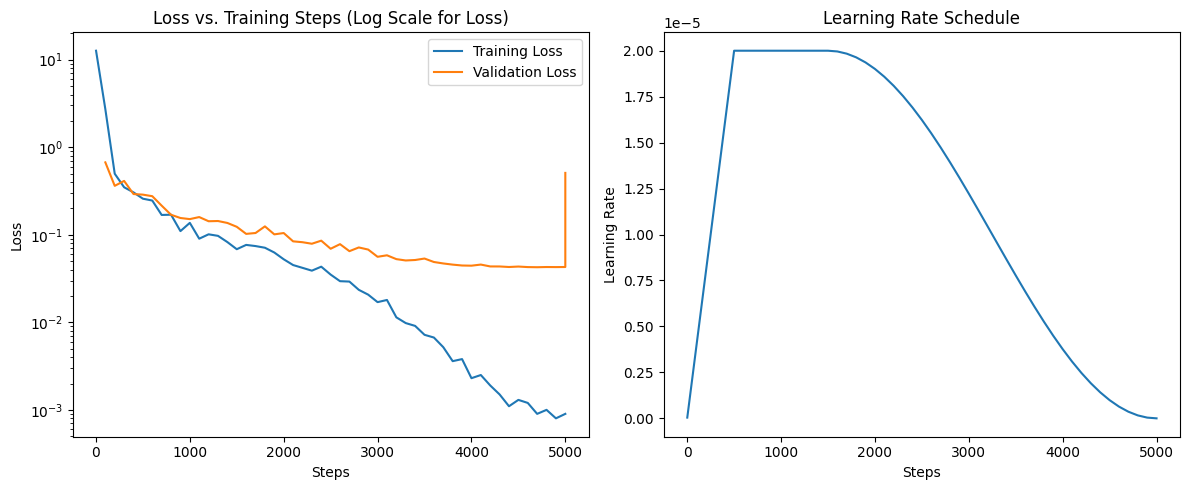

In [25]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = []
train_steps = []

eval_loss = []
eval_steps = []

learning_rates = []
lr_steps = []

for entry in logs:
    if "loss" in entry and "step" in entry:
        train_loss.append(entry["loss"])
        train_steps.append(entry["step"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
        eval_steps.append(entry["step"])
    if "learning_rate" in entry:
        learning_rates.append(entry["learning_rate"])
        lr_steps.append(entry["step"])

# Plotting
plt.figure(figsize=(12, 5))

# Plot Training and Evaluation Loss (log scale)
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label="Training Loss")
if eval_loss:
    plt.plot(eval_steps, eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.yscale("log")  # Only here
plt.title("Loss vs. Training Steps (Log Scale for Loss)")
plt.legend()

# Plot Learning Rate (linear scale)
plt.subplot(1, 2, 2)
plt.plot(lr_steps, learning_rates)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")

plt.tight_layout()
plt.show()


In [26]:
from torch.utils.data import DataLoader
import torch

loader = DataLoader(encoded_dataset["test"], batch_size=8)

model.eval()

examples = []
with torch.no_grad():
    for batch in loader:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze()

        # Rescale predictions and labels from [0,1] → [0,5]
        preds_rescaled = preds
        labels_rescaled = labels

        for p, l, id_ in zip(preds_rescaled, labels_rescaled, input_ids):
            text_pair = tokenizer.decode(id_, skip_special_tokens=False)
            examples.append((text_pair, p.item(), l.item()))

        if len(examples) >= 5:
            break

for i, (text_pair, pred, label) in enumerate(examples[:5]):
    print(f"Example {i+1}")
    print(f"📝 Sentence Pair: {text_pair}")
    print(f"📊 Predicted Similarity: {pred:.4f}")
    print(f"✅ Ground Truth: {label:.4f}")
    print("-" * 50)


Example 1
📝 Sentence Pair: [CLS] o cachorro caramelo está assistindo um cachorro castanho que está nadando em uma lagoa[SEP] um cachorro de estimação está de pé no banco e está olhando outro cachorro , que é castanho , na lagoa[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PA